# Notebook 1 — Complete analysis

This notebook performs a complete analysis of the provided datasets:
- `historical_data.csv` (trades / PnL / side / size / timestamp)
- `fear_greed_index.csv` (market sentiment index)

The notebook includes data loading, cleaning, daily aggregation, visualizations, merging with the Fear & Greed index, and suggested next steps. If you run this in Google Colab, either upload the two CSVs to the session or mount your Google Drive and update the paths accordingly.


## 1) Setup — imports and configuration

Run this cell first to import required libraries and set plotting defaults.

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import display

# Plotting defaults
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['figure.dpi'] = 100

DATA_DIR = r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files'
# adjust if running in Colab or a different environment


## 2) Load datasets

This cell attempts to load the two CSVs from `/mnt/data`. If running in Colab, upload the files and update the paths.

In [6]:
# Paths (update if necessary)
hist_path = os.path.join(DATA_DIR, 'historical_data.csv')
fg_path = os.path.join(DATA_DIR, 'fear_greed_index.csv')

print('Looking for files:')
print(hist_path)
print(fg_path)

assert os.path.exists(hist_path), f"historical_data.csv not found at {hist_path}"
assert os.path.exists(fg_path), f"fear_greed_index.csv not found at {fg_path}"

hist = pd.read_csv(hist_path)
fg = pd.read_csv(fg_path)

print('\nLoaded datasets:')
print('historical_data shape:', hist.shape)
print('fear_greed_index shape:', fg.shape)

display(hist.head())
display(fg.head())


Looking for files:
C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\historical_data.csv
C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\fear_greed_index.csv

Loaded datasets:
historical_data shape: (211224, 16)
fear_greed_index shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


## 3) Inspect columns and identify date / pnl / size / side columns

This cell tries to automatically detect common column names. If column detection fails, please update the column names manually below.

In [7]:
print('Columns in historical data:')
for c in hist.columns:
    print('-', c)

# Heuristics to find useful columns
time_col = None
for col in ['time','Time','date','Date','timestamp','datetime','created_at']:
    if col in hist.columns:
        time_col = col
        break
if time_col is None:
    for col in hist.columns:
        if 'time' in col.lower() or 'date' in col.lower():
            time_col = col
            break

pnl_col = None
for col in hist.columns:
    if 'pnl' in col.lower():
        pnl_col = col
        break

size_col = None
for col in hist.columns:
    if col.lower() in ['size','qty','quantity','volume']:
        size_col = col
        break
if size_col is None:
    for col in hist.columns:
        if 'size' in col.lower() or 'qty' in col.lower() or 'volume' in col.lower():
            size_col = col
            break

side_col = None
for col in hist.columns:
    if col.lower() in ['side','Side','buy_sell','direction','trade_type']:
        side_col = col
        break
if side_col is None:
    for col in hist.columns:
        if 'side' in col.lower() or 'buy' in col.lower() or 'sell' in col.lower():
            side_col = col
            break

print('\nDetected (or nearest guess):')
print('time_col =', time_col)
print('pnl_col =', pnl_col)
print('size_col =', size_col)
print('side_col =', side_col)

print('\nIf any of these are None or incorrect, edit them manually in the next cell.')


Columns in historical data:
- Account
- Coin
- Execution Price
- Size Tokens
- Size USD
- Side
- Timestamp IST
- Start Position
- Direction
- Closed PnL
- Transaction Hash
- Order ID
- Crossed
- Fee
- Trade ID
- Timestamp

Detected (or nearest guess):
time_col = Timestamp IST
pnl_col = Closed PnL
size_col = Size Tokens
side_col = Side

If any of these are None or incorrect, edit them manually in the next cell.


### 3b) (Optional) Manually set column names
If the automatic detection above didn't find the right columns, edit the names below (uncomment and modify) and run the cell.

In [8]:
# Example manual overrides (uncomment and edit if needed):
# time_col = 'timestamp'
# pnl_col = 'closedPnL'
# size_col = 'size'
# side_col = 'side'
try:
    _ = time_col
except NameError:
    time_col = None
try:
    _ = pnl_col
except NameError:
    pnl_col = None
try:
    _ = size_col
except NameError:
    size_col = None
try:
    _ = side_col
except NameError:
    side_col = None

print('Using: time_col=', time_col, 'pnl_col=', pnl_col, 'size_col=', size_col, 'side_col=', side_col)


Using: time_col= Timestamp IST pnl_col= Closed PnL size_col= Size Tokens side_col= Side


## 4) Cleaning and feature engineering
Parse datetimes, create `date` column, clean PnL, size, and side columns.

In [9]:
# --- parse datetime ---
if time_col is None:
    raise ValueError('time_col not set. Please set time_col to the timestamp column name.')
hist['time_parsed'] = pd.to_datetime(hist[time_col], errors='coerce')
hist['date'] = hist['time_parsed'].dt.date

# --- pnl ---
if pnl_col is None:
    # fallback: try to find any column with 'pnl' in its name
    for col in hist.columns:
        if 'pnl' in col.lower():
            pnl_col = col
            break
if pnl_col is None:
    raise ValueError('Could not find a PnL column. Please set pnl_col manually.')
hist['closedPnL_clean'] = pd.to_numeric(hist[pnl_col], errors='coerce').fillna(0)

# --- size / volume ---
if size_col is None:
    for col in hist.columns:
        if 'size' in col.lower() or 'qty' in col.lower() or 'volume' in col.lower():
            size_col = col
            break
if size_col is None:
    raise ValueError('Could not find a size/volume column. Please set size_col manually.')
hist['size_clean'] = pd.to_numeric(hist[size_col], errors='coerce').fillna(0).abs()

# --- side ---
if side_col is None:
    # fallback to inferring from sign of size
    hist['side_clean'] = hist['size_clean'].apply(lambda x: 'buy' if x >= 0 else 'sell')
else:
    hist['side_clean'] = hist[side_col].astype(str).str.lower().str.strip()

display(hist[[time_col,'time_parsed','date',pnl_col,size_col, 'side_clean']].head())


,Timestamp IST,time_parsed,date,Closed PnL,Size Tokens,side_clean
0,02-12-2024 22:50,2024-02-12 22:50:00,2024-02-12,0.0,986.87,buy
1,02-12-2024 22:50,2024-02-12 22:50:00,2024-02-12,0.0,16.00,buy
2,02-12-2024 22:50,2024-02-12 22:50:00,2024-02-12,0.0,144.09,buy
3,02-12-2024 22:50,2024-02-12 22:50:00,2024-02-12,0.0,142.98,buy
4,02-12-2024 22:50,2024-02-12 22:50:00,2024-02-12,0.0,8.73,buy


## 5) Daily aggregation
Compute per-day: sum closed PnL, daily volume (sum of |size|), counts of buy/sell trades, total trades.

In [16]:
daily = hist.groupby('date').agg(
    daily_closedPnL = ('closedPnL_clean', 'sum'),
    daily_volume = ('size_clean', 'sum'),
    buy_trades = ('side_clean', lambda s: (s=='buy').sum()),
    sell_trades = ('side_clean', lambda s: (s=='sell').sum()),
    total_trades = ('side_clean', 'count')
).reset_index()
daily['date'] = pd.to_datetime(daily['date'])
daily = daily.sort_values('date')
display(daily.head())
print('\nSaved daily aggregates to ' r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\daily_aggregates.csv')
daily.to_csv(r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\daily_aggregates.csv', index=False)


,date,daily_closedPnL,daily_volume,buy_trades,sell_trades,total_trades
0,2023-01-05,0.000000,2.513000e-01,3,0,3
1,2023-05-12,0.000000,1.180901e+01,7,2,9
2,2024-01-01,-129.531460,4.178787e+03,10,8,18
3,2024-01-02,0.000000,4.498600e+04,6,0,6
4,2024-01-03,8244.241409,2.598468e+07,37,100,137



Saved daily aggregates to C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\daily_aggregates.csv


## 6) Visualizations
Three required visualizations:
1. Daily Closed PnL Over Time
2. Daily Trading Volume Over Time
3. Daily Buy vs. Sell Trades Over Time

All plots will be shown inline and saved to `C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files` so they can be downloaded.

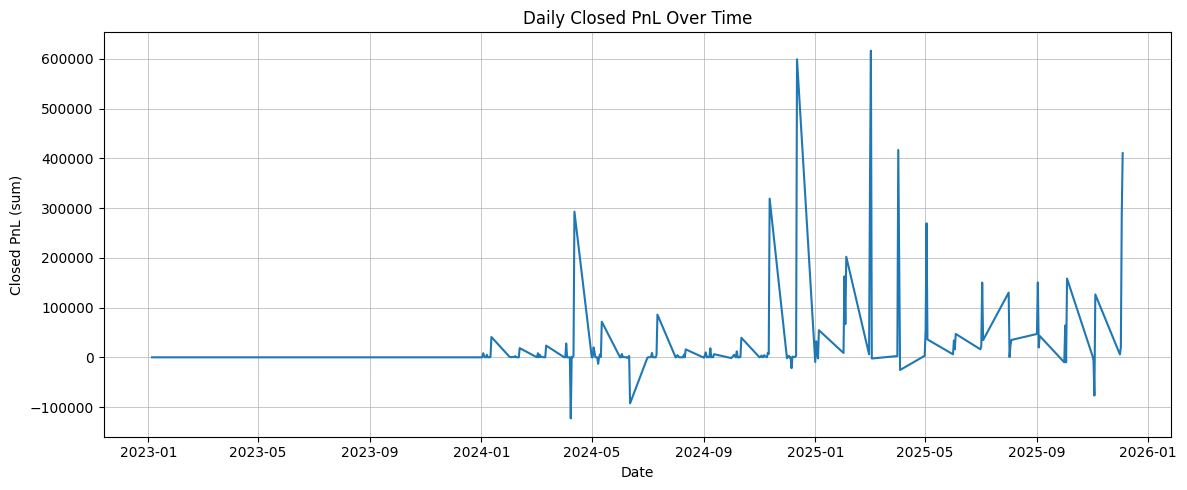

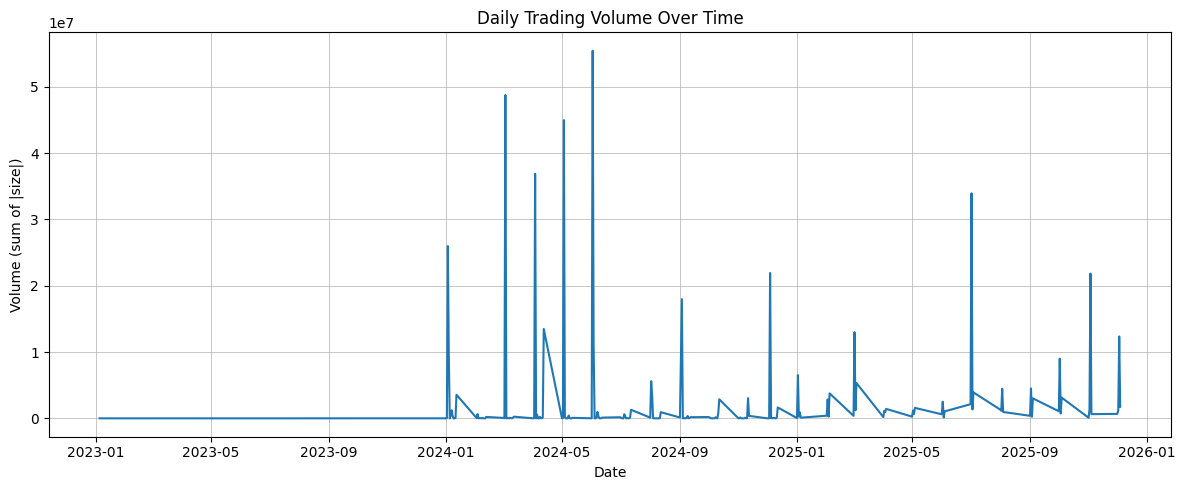

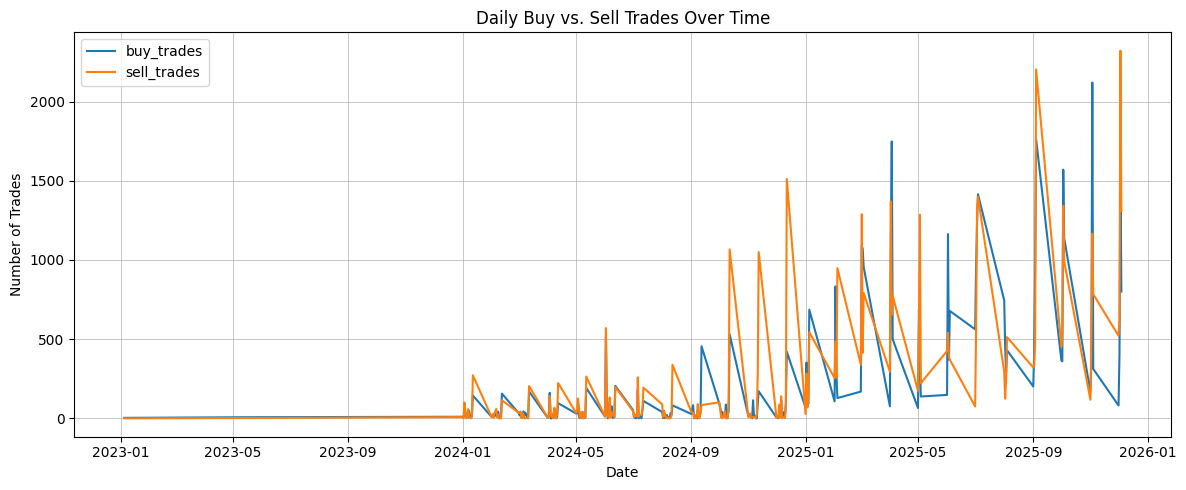

In [17]:
# 1) Daily Closed PnL
plt.figure()
plt.plot(daily['date'], daily['daily_closedPnL'])
plt.title('Daily Closed PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Closed PnL (sum)')
plt.grid(True)
plt.tight_layout()
plt.savefig(r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\outputs\daily_closed_pnl.png')
plt.show()

# 2) Daily Volume
plt.figure()
plt.plot(daily['date'], daily['daily_volume'])
plt.title('Daily Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume (sum of |size|)')
plt.grid(True)
plt.tight_layout()
plt.savefig(r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\outputs\daily_trading_volume.png')
plt.show()

# 3) Buy vs Sell trades
plt.figure()
plt.plot(daily['date'], daily['buy_trades'], label='buy_trades')
plt.plot(daily['date'], daily['sell_trades'], label='sell_trades')
plt.title('Daily Buy vs. Sell Trades Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Trades')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\outputs\daily_buy_vs_sell.png')
plt.show()


## 7) Merge daily aggregates with Fear & Greed index
This helps identify whether extreme PnL or volume days co-occur with changes in market sentiment.

In [18]:
# Attempt common date column names in fear & greed file
print('Fear & Greed columns: ', fg.columns.tolist())
fg_date_col = None
for c in fg.columns:
    if c.lower() in ['date','day','timestamp'] or 'date' in c.lower():
        fg_date_col = c
        break
if fg_date_col is None:
    raise ValueError('Could not detect date column in fear & greed file. Please set fg_date_col manually.')
fg['date_parsed'] = pd.to_datetime(fg[fg_date_col], errors='coerce').dt.date
fg_daily = fg.copy()
fg_daily['date'] = pd.to_datetime(fg_daily['date_parsed'])

merged = pd.merge(daily, fg_daily, on='date', how='left')
display(merged.head())
merged.to_csv(r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\fear_greed_index.csv', index=False)
print('\nSaved merged file to 'r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\fear_greed_index.csv')


Fear & Greed columns:  ['timestamp', 'value', 'classification', 'date', 'date_parsed']


,date,daily_closedPnL,daily_volume,buy_trades,sell_trades,total_trades,timestamp,value,classification,date_parsed
0,2023-01-05,0.000000,2.513000e-01,3,0,3,NaN,NaN,NaN,NaN
1,2023-05-12,0.000000,1.180901e+01,7,2,9,NaN,NaN,NaN,NaN
2,2024-01-01,-129.531460,4.178787e+03,10,8,18,NaN,NaN,NaN,NaN
3,2024-01-02,0.000000,4.498600e+04,6,0,6,NaN,NaN,NaN,NaN
4,2024-01-03,8244.241409,2.598468e+07,37,100,137,NaN,NaN,NaN,NaN



Saved merged file to C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\fear_greed_index.csv


## 8) Quick statistics & observations
Compute summary statistics and identify extreme days.

In [19]:
summary = {
    'period_start': str(daily['date'].min()) if not daily.empty else 'N/A',
    'period_end': str(daily['date'].max()) if not daily.empty else 'N/A',
    'num_days': int(daily.shape[0]),
    'mean_daily_closedPnL': float(daily['daily_closedPnL'].mean()),
    'median_daily_closedPnL': float(daily['daily_closedPnL'].median()),
    'mean_daily_volume': float(daily['daily_volume'].mean())
}
import json
print(json.dumps(summary, indent=2))

print('\nTop 5 profit days:')
display(daily.sort_values('daily_closedPnL', ascending=False).head(5))
print('\nTop 5 loss days:')
display(daily.sort_values('daily_closedPnL', ascending=True).head(5))


{
  "period_start": "2023-01-05 00:00:00",
  "period_end": "2025-12-04 00:00:00",
  "num_days": 188,
  "mean_daily_closedPnL": 30207.260811292548,
  "median_daily_closedPnL": 862.3430035,
  "mean_daily_volume": 2542235.3544059014
}

Top 5 profit days:


,date,daily_closedPnL,daily_volume,buy_trades,sell_trades,total_trades
150,2025-03-03,616413.032233,1.215236e+06,1069,413,1482
138,2024-12-12,599151.795008,1.644131e+06,421,1511,1932
153,2025-04-02,416876.888120,1.144231e+06,1143,1369,2512
187,2025-12-04,410419.694533,1.734380e+06,800,1309,2109
149,2025-03-02,348871.326269,1.299375e+07,1091,1289,2380



Top 5 loss days:


,date,daily_closedPnL,daily_volume,buy_trades,sell_trades,total_trades
43,2024-04-08,-122672.000883,2.270497e+05,60,67,127
71,2024-06-12,-92624.643895,1.086766e+05,205,198,403
182,2025-11-03,-76880.729036,2.183851e+07,2120,1166,3286
155,2025-04-04,-25515.678950,1.425479e+06,499,773,1272
133,2024-12-06,-21886.531493,3.710551e+04,115,139,254


## 9) Suggestions for further analysis

- Investigate the trades (rows) that contributed to extreme profit/loss days (filter `hist` by the date).
- Check correlation between `daily_volume` / `daily_closedPnL` and the Fear & Greed value (after confirming the FG column name).
- Build rolling-window features (7-day, 30-day moving averages) and test a simple strategy using buy/sell imbalance.
- Use more granular (intraday) signals if available for more precise strategy building.


## 10) Save artifacts
The notebook saves key artifacts to `/mnt/data/` so you can download them after running this notebook.

In [20]:
artifacts = [
    r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\daily_aggregates.csv',
    r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\fear_greed_index.csv',
    r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\outputs\daily_closed_pnl.png',
    r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\outputs\daily_trading_volume.png',
    r'C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\outputs\daily_buy_vs_sell.png'
]
for a in artifacts:
    print('-', a, 'exists?' , os.path.exists(a))

print('\nIf you run this in Colab and want these files in Drive, mount Drive and copy them there.')


- C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\daily_aggregates.csv exists? True
- C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\csv_files\fear_greed_index.csv exists? True
- C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\outputs\daily_closed_pnl.png exists? True
- C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\outputs\daily_trading_volume.png exists? True
- C:\Users\hulkh\Downloads\ds_Siva_Venkata_Bhanu_Prakash\outputs\daily_buy_vs_sell.png exists? True

If you run this in Colab and want these files in Drive, mount Drive and copy them there.
